# RT-HF with Density Matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf_interface import *

π = np.pi
α = 0.007297352
c = 1.0/α
np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

### Let's intialize the molecules

In [2]:
### Hydrogen cyanide / HCN
Z_HCN = np.array(["N", "C", "H"])
R_HCN = np.array([[-0.5800,    0.0000,    0.0000], [ 0.5800,    0.0000,    0.0000], [ 1.6450,    0.0000,    0.0000]])

### Hydroxide (OH)
Z_OH = np.array(["O", "H"])
R_OH = np.array([[ 0., 0., 3.], [0., 0., 2.]])

HCN = pyscf_UHF()
HCN.initialize(xyz=R_HCN, Z=Z_HCN, charge=0, basis="sto-3g")
HCN.Calc()

OH = pyscf_UHF()
OH.initialize(xyz=R_OH, Z=Z_OH, charge=0, basis="sto-3g")
OH.Calc()

converged SCF energy = -91.6750347450802  <S^2> = 1.3500312e-13  2S+1 = 1
converged SCF energy = -74.3646755621034  <S^2> = 0.75399096  2S+1 = 2.003987


### Next lets initialize the field

In [101]:
field3 = E_field()
field3.E0 = 1e-5
field3.ω  = 0.25
field3.Γ  = 1.
field3.vector = np.array([1.,1.,1.])

### UT Integration Scheme

In [20]:
def RTHF_UT(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    d_tx   = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        # get AO density matrices
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
        d_tx[step]  = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        # compute FA, FB and transform to MO basis
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        FA = (uhf_object.Ca).T @ FA_ao @ (uhf_object.Ca)
        FB = (uhf_object.Cb).T @ FB_ao @ (uhf_object.Cb)
            
        # compute propagators
        UA  = Expm( -1j*(dt)*FA )
        UB  = Expm( -1j*(dt)*FB )
        #Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
        
        ### full step forward
        DA_t  = (UA) @ DA_t @ (UA.conj().T)
        DB_t  = (UB) @ DB_t @ (UB.conj().T)
        
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy

### MMUT Integration Scheme

In [77]:
def RTHF_MMUT(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 1000, onoff=1.0, field=None):
    
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*uhf_object.Da_mo
    if DB_t is None:
        DB_t = 1.*uhf_object.Db_mo
    if field is None:
        def field(t):
            return np.zeros(3)
    
    ### compute initial half step propagators?
    FA0_mo  = np.diag(uhf_object.Ea)
    FB0_mo  = np.diag(uhf_object.Eb)
    UA_half = Expm( -1j*FA0_mo*dt/2 ) #!!!
    UB_half = Expm( -1j*FB0_mo*dt/2 ) #!!!
    DA_half = (UA_half.conj().T) @ DA_t @ (UA_half)
    DB_half = (UB_half.conj().T) @ DB_t @ (UB_half)
    
    
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    J = np.zeros((tsteps, 2, len(uhf_object.Da_mo), len(uhf_object.Da_mo)), dtype=complex)
    for step in tqdm(range(tsteps)):
        t = step * dt
    
        # get AO density matrices
        DA_ao = ( uhf_object.Ca ) @ DA_t @ ( (uhf_object.Ca).T)
        DB_ao = ( uhf_object.Cb ) @ DB_t @ ( (uhf_object.Cb).T)
        trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
        
        # save to current
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        J[step, 0] = DA_t
        J[step, 1] = DB_t
        
        # compute FA_t, FB_t
        FA_ao, FB_ao = uhf_object.get_UFock(DA_ao, DB_ao) - onoff * np.einsum('xmn, x -> mn', uhf_object.D, field.getEE(t) )
        energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        FA = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca)
        FB = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        
        # compute propagators
        UA_half = Expm( -1j*FA*dt ) #!!!
        UB_half = Expm( -1j*FB*dt ) #!!!
        
        # half step forward
        DA_half = (UA_half) @ DA_half @ (UA_half.conj().T)
        DB_half = (UB_half) @ DB_half @ (UB_half.conj().T)
        
        # get AO density matrices
        DA_ao = ( uhf_object.Ca ) @ DA_half @ ( (uhf_object.Ca).T)
        DB_ao = ( uhf_object.Cb ) @ DB_half @ ( (uhf_object.Cb).T)
        
        # compute FA_t, FB_t
        t = (step + 0.5) * dt
        FA_ao, FB_ao = uhf_object.get_UFock(DA_ao, DB_ao) - onoff * np.einsum('xmn, x -> mn', uhf_object.D, field.getEE(t) )
        FA = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca)
        FB = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        
        # compute propagators
        UA  = Expm( -1j*FA*dt ) #!!!
        UB  = Expm( -1j*FB*dt ) #!!!        
        
        # full step forward
        DA_t = (UA) @ DA_t @ (UA.conj().T)
        DB_t = (UB) @ DB_t @ (UB.conj().T)
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy ##J

### RK4 Integration Scheme

In [17]:
def RTHF_RK4(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    trace  = np.zeros(tsteps)
    energy = np.zeros(tsteps)
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step]  = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1_αe = -1j*(F_t_αe@DA_t - DA_t@F_t_αe)
        K1_βe = -1j*(F_t_βe@DB_t - DB_t@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K1_αe
        tempD_βe = DB_t + 0.5 * dt * K1_βe
        
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K2_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K2_αe
        tempD_βe = DB_t + 0.5 * dt * K2_βe
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K3_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 1.0 * dt * K3_αe
        tempD_βe = DB_t + 1.0 * dt * K3_βe
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K4_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        DA_t += (dt/6.0) * (K1_αe + 2.0 * K2_αe + 2.0 * K3_αe + K4_αe) 
        DB_t += (dt/6.0) * (K1_βe + 2.0 * K2_βe + 2.0 * K3_βe + K4_βe)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy

### RK2 Integration Scheme

In [15]:
def RTHF_RK2(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 2nd Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        tempD_αe = DA_t + K1A
        tempD_βe = DB_t + K1B
        
        
        # compute K2
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe) * dt
        K2B = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe) * dt
        
        DA_t += (1/2.) * (K1A + K2A) 
        DB_t += (1/2.) * (K1B + K2B)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy

### RKMK4 Integration Scheme

In [6]:
def RTHF_RKMK4(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    trace  = np.zeros(tsteps)
    energy = np.zeros(tsteps)
    time   = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx   = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta MK 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step]   = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        trace[step]  = np.einsum("ii -> ", DA_t + DB_t).real
        
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        P2A = Expm(0.5* K1A) @ DA_t
        P2B = Expm(0.5* K1B) @ DB_t
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ P2A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P2B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@P2A - P2A@F_t_αe) * dt
        K2B = -1j*(F_t_βe@P2B - P2B@F_t_βe) * dt
        
        P3A = Expm(0.5* K2A - 0.125* (K1A @ K2A - K2A @ K1A) ) @ DA_t
        P3B = Expm(0.5* K2B - 0.125* (K1B @ K2B - K2B @ K1B) ) @ DB_t
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ P3A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P3B @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3A = -1j*(F_t_αe@P3A - P3A@F_t_αe) * dt
        K3B = -1j*(F_t_βe@P3B - P3B@F_t_βe) * dt
        
        P4A = Expm(K3A) @ DA_t
        P4B = Expm(K3B) @ DB_t
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ P4A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P4B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4A = -1j*(F_t_αe@P4A - P4A@F_t_αe) * dt
        K4B = -1j*(F_t_βe@P4B - P4B@F_t_βe) * dt
        
        DA_t = Expm( (1/6.) * (K1A + 2.*K2A + 2.*K3A + K4A - 0.5*(K1A @ K4A - K4A @ K1A) ) ) @ DA_t
        DB_t = Expm( (1/6.) * (K1B + 2.*K2B + 2.*K3B + K4B - 0.5*(K1B @ K4B - K4B @ K1B) ) ) @ DB_t
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy

## Results
##### MO Density Matrix Trace: trace
##### Energy Conversation: energy
##### Spectra (+LR)

In [60]:
t, d_rk4, tr_rk4, E_rk4 = RTHF_RK4(OH, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [06:48<00:00, 1223.28it/s]


In [59]:
t, d_ut, tr_ut, E_ut = RTHF_UT(OH, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [02:35<00:00, 3208.71it/s]


In [30]:
t, d_rk2, tr_rk2, E_rk2 = RTHF_RK2(OH, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [03:33<00:00, 2337.75it/s]


In [84]:
t, d_mmut, tr_mmut, E_mmut = RTHF_MMUT(OH, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [04:59<00:00, 1666.81it/s]


In [58]:
t, d_rkmk4, tr_rkmk4, E_rkmk4 = RTHF_RKMK4(OH, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [10:26<00:00, 798.52it/s]


### Let's Calculate the LR for checking later...

In [122]:
OH.UCIS()
OH.UTDHF_calc()
ω_LR = OH.TDHF_E[:-1]
f_LR = OH.TDHF_f[:-1]

def LorentzianA(ω, ω0, f, Γ):
    ω = (ω + 1j*Γ)**2
    
    ww0 = np.einsum("w, v -> wv", ω, np.ones(ω0.shape)) - np.einsum("v,w -> wv", ω0**2, np.ones(ω.shape))
    return np.einsum("v, wv -> w", -f, 1/(ww0) )

α_ω = LorentzianA(ω, ω_LR, f_LR, 0.01)

/home/julio/Desktop/rtqd_lab/pyscf_interface.py:709: RuntimeWarning: invalid value encountered in sqrt
  Eigenvalues = np.sqrt(Eigenvalues2)


### Finaly Let's plot results

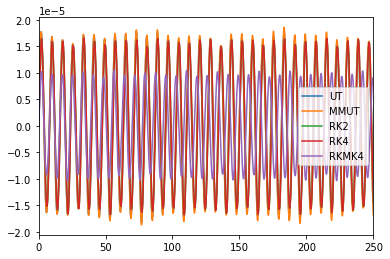

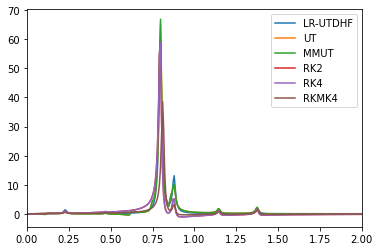

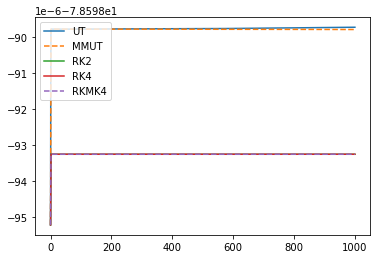

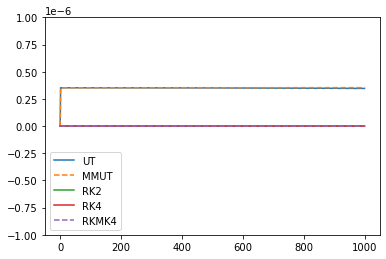

In [126]:
plt.plot(t, d_ut[:,2], label="UT")
plt.plot(t, d_mmut[:,2], label="MMUT")
plt.plot(t, d_rk2[:,2], label="RK2")
plt.plot(t, d_rk4[:,2], label="RK4")
plt.plot(t, d_rkmk4[:,2], label="RKMK4")
plt.xlim([0,250])
plt.legend()
plt.show()

ω, dω_ut    = RT_FFT(t,    d_ut, Γ=0.01)
ω, dω_mmut  = RT_FFT(t,  d_mmut, Γ=0.01)
ω, dω_rk2   = RT_FFT(t,   d_rk2, Γ=0.01)
ω, dω_rk4   = RT_FFT(t,   d_rk4, Γ=0.01)
ω, dω_rkmk4 = RT_FFT(t, d_rkmk4, Γ=0.01)
plt.plot(ω, α_ω.imag, label="LR-UTDHF")
plt.plot(ω, -np.einsum("wx -> w",    dω_ut.imag/field3.E0), label="UT")
plt.plot(ω, -np.einsum("wx -> w",  dω_mmut.imag/field3.E0), label="MMUT")
plt.plot(ω, -np.einsum("wx -> w",   dω_rk2.imag/field3.E0), label="RK2")
plt.plot(ω, -np.einsum("wx -> w",   dω_rk4.imag/field3.E0), label="RK4")
plt.plot(ω, -np.einsum("wx -> w", dω_rkmk4.imag/field3.E0), label="RKMK4")
plt.xlim([0,2])
plt.legend()
plt.show()

plt.plot(t,    E_ut, label="UT")
plt.plot(t,  E_mmut, label="MMUT", linestyle="dashed")
plt.plot(t,   E_rk2, label="RK2")
plt.plot(t,   E_rk4, label="RK4")
plt.plot(t, E_rkmk4, label="RKMK4", linestyle="dashed")
plt.legend()
plt.show()

N_electrons = (OH.Na + OH.Nb)
plt.plot(t, tr_ut    - N_electrons, label="UT")
plt.plot(t, tr_mmut  - N_electrons, label="MMUT", linestyle="dashed")
plt.plot(t, tr_rk2   - N_electrons, label="RK2")
plt.plot(t, tr_rk4   - N_electrons, label="RK4")
plt.plot(t, tr_rkmk4 - N_electrons, label="RKMK4", linestyle="dashed")
plt.ylim([-1e-6, 1e-6])
plt.legend()
plt.show()